Using device: mps
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


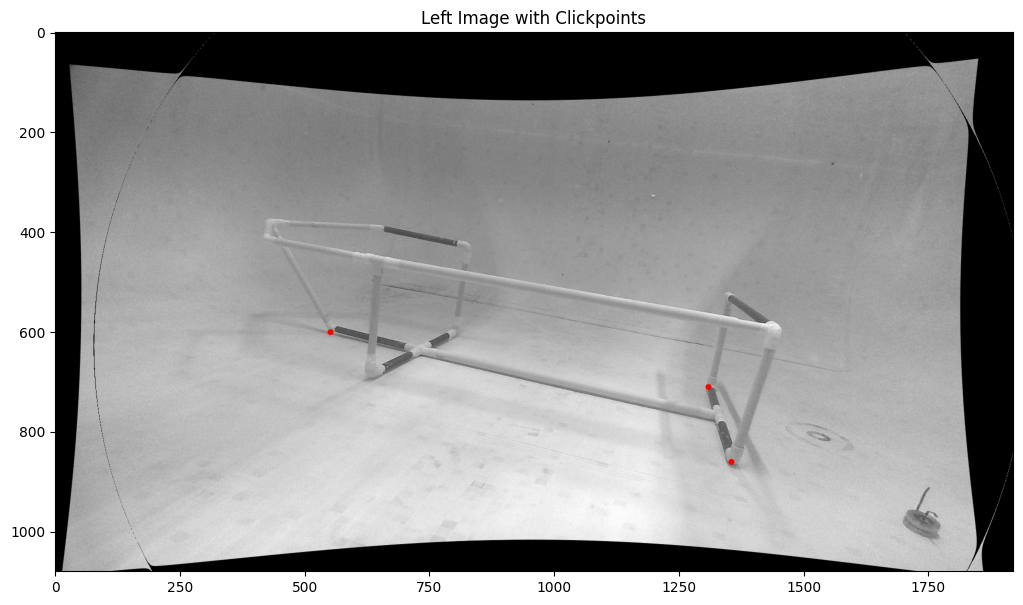

Processing click point: (551, 601)


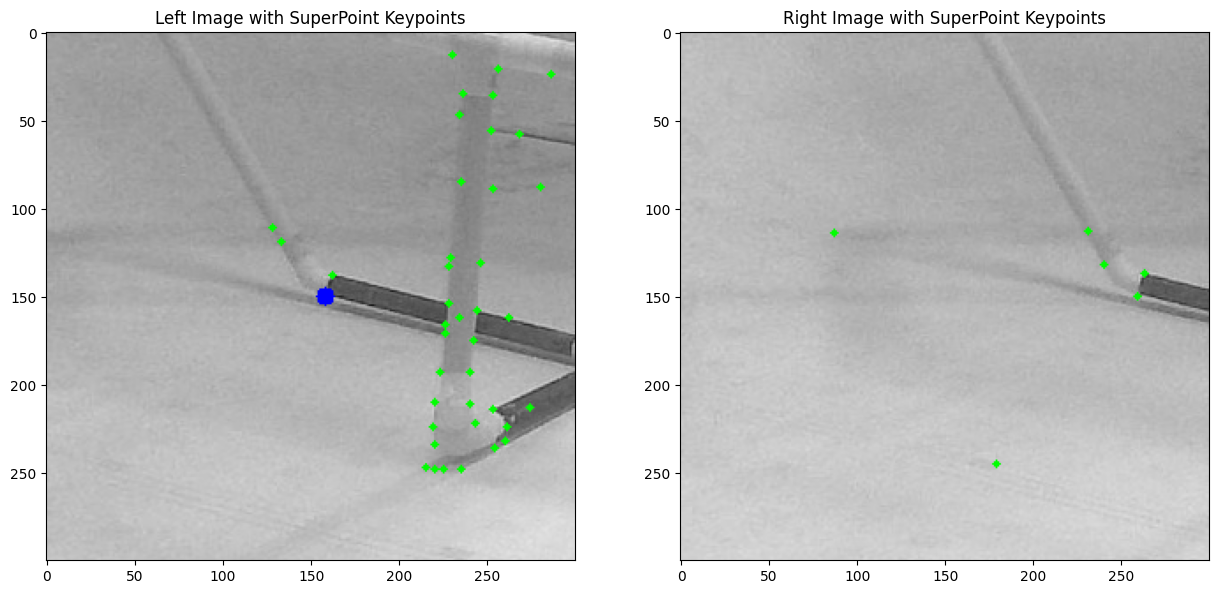

keypoints0 torch.Size([1, 1, 2])
keypoints1 torch.Size([1, 6, 2])
descriptors0 torch.Size([1, 256, 1])
descriptors1 torch.Size([1, 256, 6])
scores0 torch.Size([1, 1])
scores1 torch.Size([1, 6])
image0 torch.Size([1, 1, 300, 300])
image1 torch.Size([1, 1, 300, 300])
Found 1 valid matches
Keypoint 17: Matched to tensor([660., 601.], device='mps:0'), disparity=-101.0


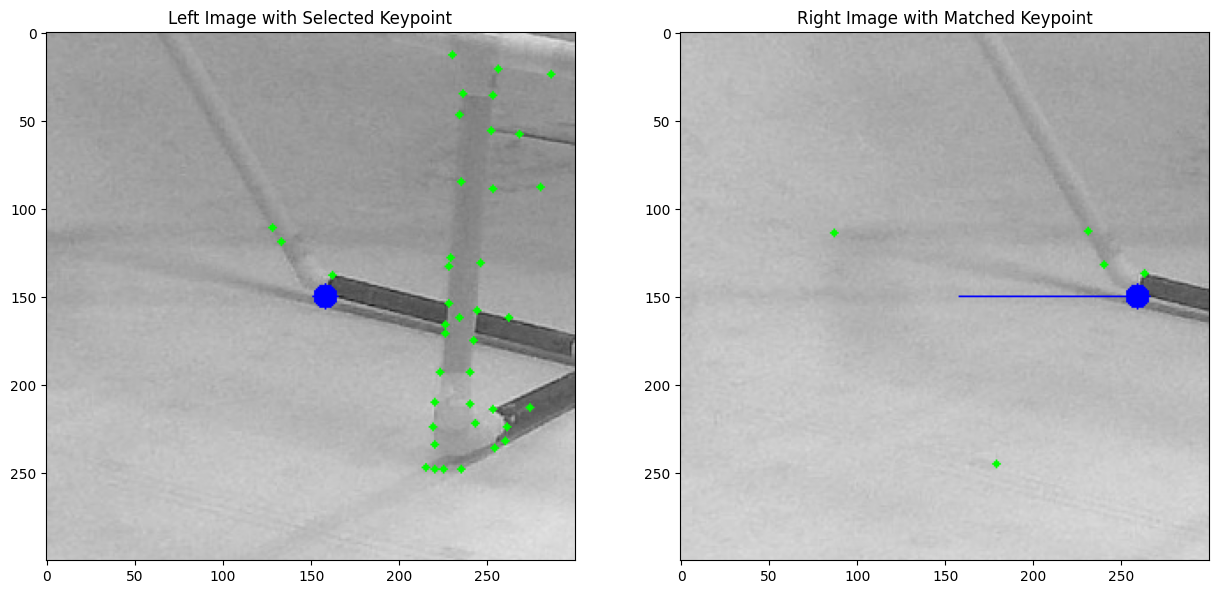

Processing click point: (1308, 711)


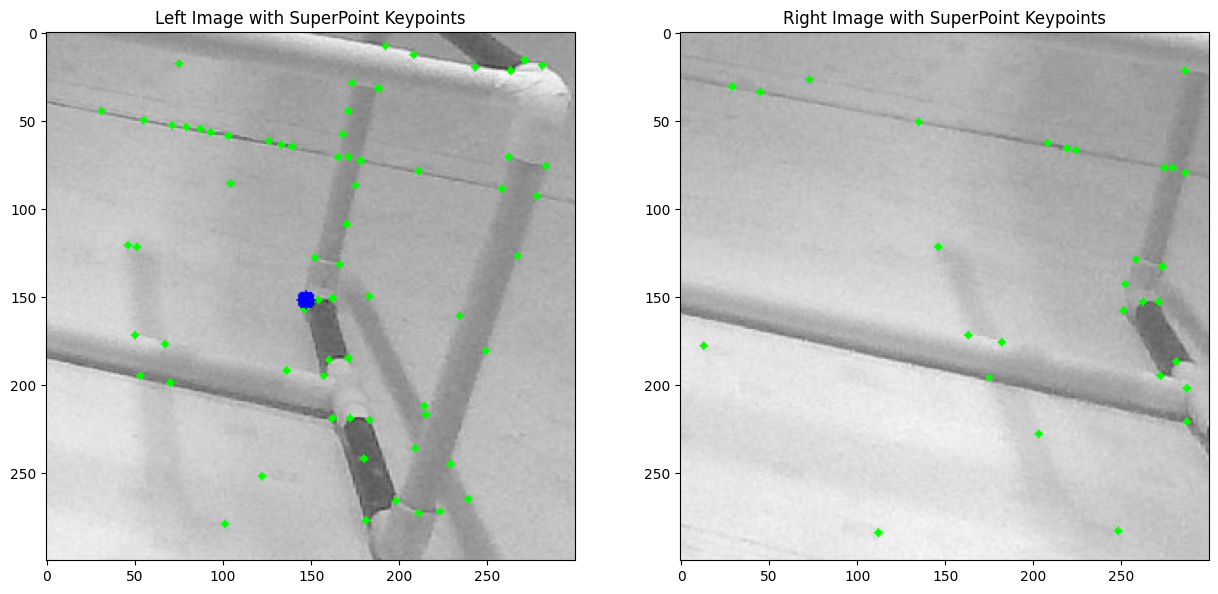

keypoints0 torch.Size([1, 1, 2])
keypoints1 torch.Size([1, 29, 2])
descriptors0 torch.Size([1, 256, 1])
descriptors1 torch.Size([1, 256, 29])
scores0 torch.Size([1, 1])
scores1 torch.Size([1, 29])
image0 torch.Size([1, 1, 300, 300])
image1 torch.Size([1, 1, 300, 300])
Found 1 valid matches
Keypoint 39: Matched to tensor([1420.,  714.], device='mps:0'), disparity=-115.0


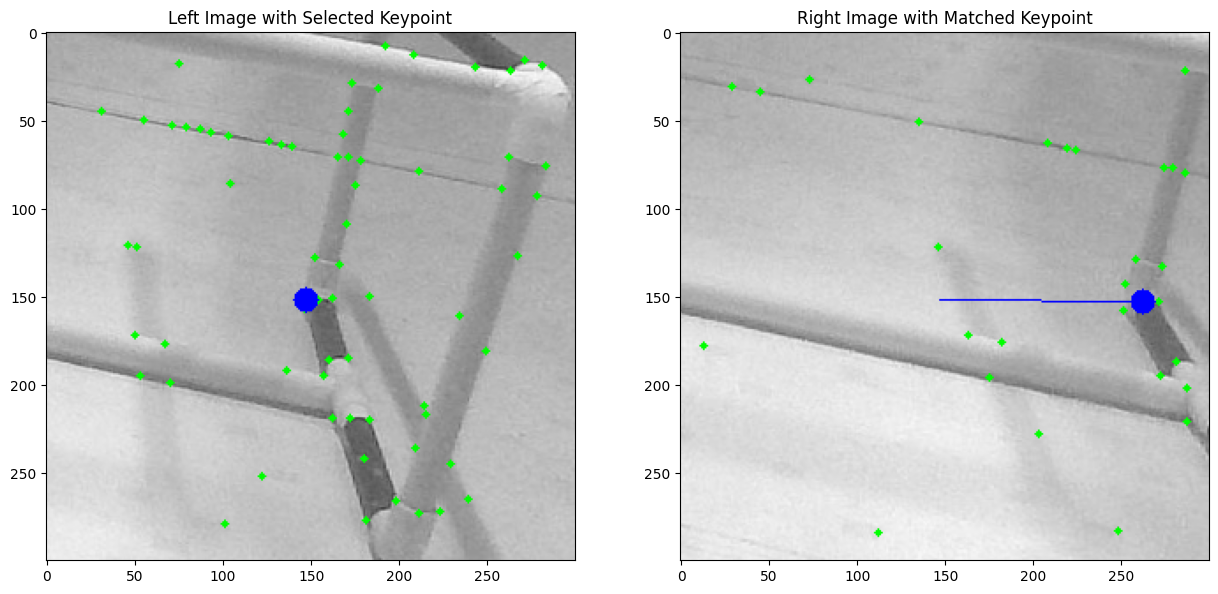

Processing click point: (1354, 861)


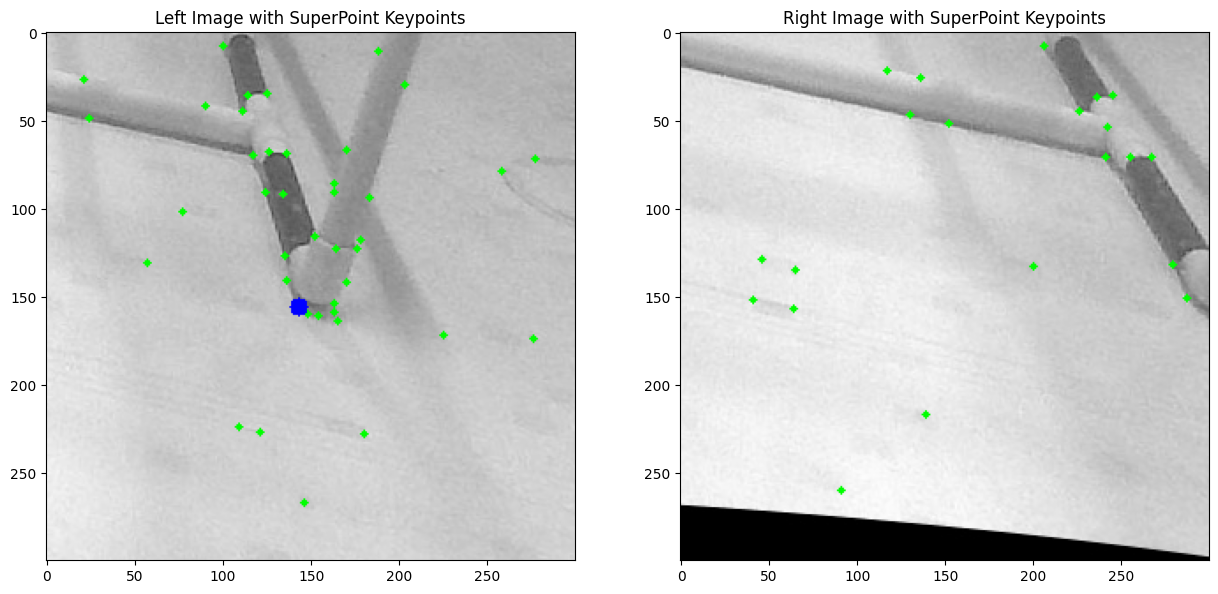

keypoints0 torch.Size([1, 1, 2])
keypoints1 torch.Size([1, 21, 2])
descriptors0 torch.Size([1, 256, 1])
descriptors1 torch.Size([1, 256, 21])
scores0 torch.Size([1, 1])
scores1 torch.Size([1, 21])
image0 torch.Size([1, 1, 300, 300])
image1 torch.Size([1, 1, 300, 300])
Found 1 valid matches
Keypoint 30: Matched to tensor([1491.,  862.], device='mps:0'), disparity=-144.0


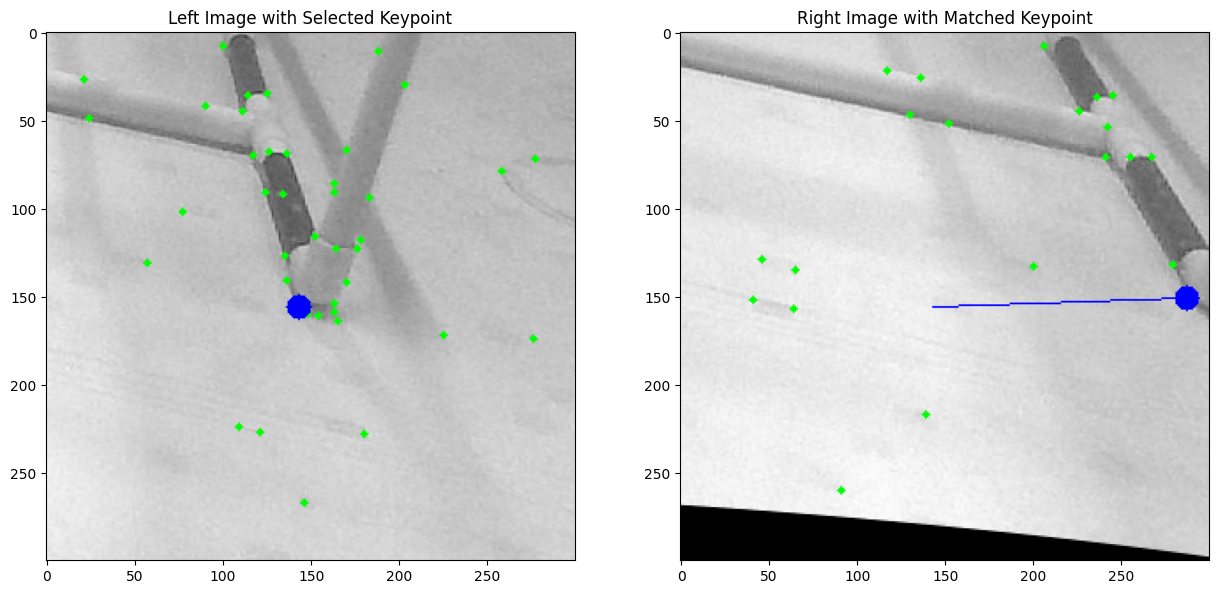


--- All Valid Matches Summary ---
Click Point: (551, 601), Query Idx: 17, Matched Point: tensor([660., 601.], device='mps:0'), Disparity: -101.0
Click Point: (1308, 711), Query Idx: 39, Matched Point: tensor([1420.,  714.], device='mps:0'), Disparity: -115.0
Click Point: (1354, 861), Query Idx: 30, Matched Point: tensor([1491.,  862.], device='mps:0'), Disparity: -144.0


In [9]:
import torch
import cv2
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.append('SuperGluePretrainedNetwork')
from SuperGluePretrainedNetwork.models.superpoint import SuperPoint
from SuperGluePretrainedNetwork.models.superglue import SuperGlue

click_points = [(551, 601), (1308, 711), (1354, 861)]  # List of click coordinates

# --- 0) Device selection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f"Using device: {device}")

sg_cfg = {
  'weights': 'outdoor',            # o 'outdoor' a seconda del dataset
  'sinkhorn_iterations': 50,
  'match_threshold': 0.005,
  'max_keypoints': 256
}

# --- 1) Load models
sp_config = {'descriptor_dim': 256, 'nms_radius': 4, 'keypoint_threshold': 0.005, 'max_keypoints': -1, 'remove_borders': 4} 
sp = SuperPoint(sp_config).to(device)  # SuperPoint
sg_cfg = {'weights': 'outdoor'}  # or 'outdoor'
sg = SuperGlue(sg_cfg).eval().to(device)                                        # SuperGlue

# --- 2) Detect features
img0 = cv2.imread('img_left_rectified.jpg',0)
img1 = cv2.imread('img_right_rectified.jpg',0)


# visualize the images and keypoints
img0_vis = cv2.cvtColor(img0, cv2.COLOR_GRAY2BGR)

for kpt in click_points:
    cv2.circle(img0_vis, (int(kpt[0]), int(kpt[1])), 6, (0, 0, 255), -1)

fig, axes = plt.subplots(1, 1, figsize=(15, 7))
axes.imshow(cv2.cvtColor(img0_vis, cv2.COLOR_BGR2RGB))
axes.set_title('Left Image with Clickpoints')
plt.show()

# --- 3) Define crop region around the clicked point
crop_size = 300  # Define the size of the cropped region
half_crop = crop_size // 2

all_valid_matches = [] # Initialize a list to store all valid matches

for x_click, y_click in click_points:
    print(f"Processing click point: ({x_click}, {y_click})")

    # --- 4) Crop the images
    y1 = max(0, y_click - half_crop)
    y2 = min(img0.shape[0], y_click + half_crop)
    x1 = max(0, x_click - half_crop)
    x2 = min(img0.shape[1], x_click + half_crop)

    img0_crop = img0[y1:y2, x1:x2]
    img1_crop = img1[y1:y2, x1:x2]

    img0_norm = img0_crop/255.0
    img1_norm = img1_crop/255.0

    img0_t = torch.from_numpy(img0_norm[None,None,...]).float().to(device)
    img1_t = torch.from_numpy(img1_norm[None,None,...]).float().to(device)

    pred0 = sp({'image': img0_t})
    pred1 = sp({'image': img1_t})

    kpts0, desc0, scores0 = pred0['keypoints'][0], pred0['descriptors'][0], pred0['scores'][0]
    kpts1, desc1, scores1 = pred1['keypoints'][0], pred1['descriptors'][0], pred1['scores'][0]

    click = np.array([x_click - x1, y_click - y1]) # Adjust click coordinates to cropped image
    dists = np.linalg.norm(kpts0.cpu().numpy() - click[None,:], axis=1)
    radius = 10 # Define the radius for selecting keypoints
    idxs0 = np.where(dists < radius)[0] # Find keypoints within the radius
    
    
    # Find the nearest keypoint within the radius
    if len(idxs0) > 0:
        nearest_idx = idxs0[np.argmin(dists[idxs0])]
        idxs0 = np.array([nearest_idx])  # Keep only the nearest keypoint

    if len(idxs0) == 0:
        print("No keypoints found within the specified radius.")
        continue

    query_kpts = kpts0[idxs0] # Select multiple keypoints
    desc0_sel = desc0[:,idxs0].to(device) # Select corresponding descriptors
    scores0_sel = scores0[idxs0].to(device)

    # --- 6) Prepare full right set for SuperGlue
    kpts1_t = kpts1.float().to(device)
    desc1_t = desc1.to(device)
    scores1_t = scores1.to(device)

    # --- Visualization of keypoints ---
    img0_vis = cv2.cvtColor(img0_crop, cv2.COLOR_GRAY2BGR)
    img1_vis = cv2.cvtColor(img1_crop, cv2.COLOR_GRAY2BGR)

    kpts0_np = kpts0.cpu().numpy()
    kpts1_np = kpts1.cpu().numpy()

    for kpt in kpts0_np:
        cv2.circle(img0_vis, (int(kpt[0]), int(kpt[1])), 2, (0, 255, 0), -1)
    for kpt in kpts1_np:
        cv2.circle(img1_vis, (int(kpt[0]), int(kpt[1])), 2, (0, 255, 0), -1)
    
    # Highlight selected keypoints in the left image
    for idx in idxs0:
        kpt = kpts0_np[idx]
        cv2.circle(img0_vis, (int(kpt[0]), int(kpt[1])), 5, (255, 0, 0), -1) # Blue for selected keypoints

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(cv2.cvtColor(img0_vis, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Left Image with SuperPoint Keypoints')
    axes[1].imshow(cv2.cvtColor(img1_vis, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Right Image with SuperPoint Keypoints')
    plt.show()

    # --- 7) Run SuperGlue
    input_data = {
      'keypoints0': query_kpts[None, ...],
      'keypoints1': kpts1_t[None, ...],
      'descriptors0': desc0_sel[None,...],
      'descriptors1': desc1_t[None,...],
      'scores0': scores0_sel[None,...],
      'scores1': scores1_t[None,...],
      'image0': img0_t,
      'image1': img1_t
    }
    for k, v in input_data.items():
        print(k, v.shape)    
    
    with torch.no_grad():
        pred = sg(input_data)
        matches0, matches1 = pred['matches0'], pred['matches1']
        confidence = pred['matching_scores0']

    # --- 8) Extract the match and visualize
    valid_matches = matches0[matches0 > -1]
    if len(valid_matches) > 0:
        print(f"Found {len(valid_matches)} valid matches")
        
        # Store the valid matches
        for i, match_idx in enumerate(valid_matches):
            query_idx = idxs0[i]
            matched_pt = kpts1[match_idx]
            disparity = kpts0[query_idx][0].cpu().numpy() - matched_pt[0].cpu().numpy()
            matched_pt[0] = matched_pt[0] + x1 #back to original coordinates
            matched_pt[1] = matched_pt[1] + y1
            print(f"Keypoint {query_idx}: Matched to {matched_pt}, disparity={disparity}")
            all_valid_matches.append({'click_point': (x_click, y_click), 'query_idx': query_idx, 'matched_pt': matched_pt, 'disparity': disparity})
            
            cv2.circle(img0_vis, (int(kpts0[query_idx][0].cpu().numpy()), int(kpts0[query_idx][1].cpu().numpy())), 7, (255, 0, 0), -1) # Blue for left
            cv2.circle(img1_vis, (int(matched_pt[0].cpu().numpy()-x1), int(matched_pt[1].cpu().numpy()-y1)), 7, (255, 0, 0), -1) # Blue for right
            cv2.line(img1_vis, (int(kpts0[query_idx][0].cpu().numpy()), int(kpts0[query_idx][1].cpu().numpy())), (int(matched_pt[0].cpu().numpy()-x1), int(matched_pt[1].cpu().numpy()-y1)), (255, 0, 0), 1)
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 7))
        axes[0].imshow(cv2.cvtColor(img0_vis, cv2.COLOR_BGR2RGB))
        axes[0].set_title('Left Image with Selected Keypoint')
        axes[1].imshow(cv2.cvtColor(img1_vis, cv2.COLOR_BGR2RGB))
        axes[1].set_title('Right Image with Matched Keypoint')
        plt.show()
        
    else:
        print("No valid match found")

print("\n--- All Valid Matches Summary ---")
for match in all_valid_matches:
    print(f"Click Point: {match['click_point']}, Query Idx: {match['query_idx']}, Matched Point: {match['matched_pt']}, Disparity: {match['disparity']}")

P1:
 [[976.0551334    0.         975.76013184   0.        ]
 [  0.         976.0551334  589.78937531   0.        ]
 [  0.           0.           1.           0.        ]]
P2:
 [[9.76055133e+02 0.00000000e+00 9.75760132e+02 1.62336083e+05]
 [0.00000000e+00 9.76055133e+02 5.89789375e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
3D coordinates of Point 1: [-519.968      18.460743 1607.2881  ]
Midpoint between Point 2 and Point 3: [ 618.78906  247.01996 1269.476  ]
Distance between Point 1 and the midpoint: 1209.5966796875


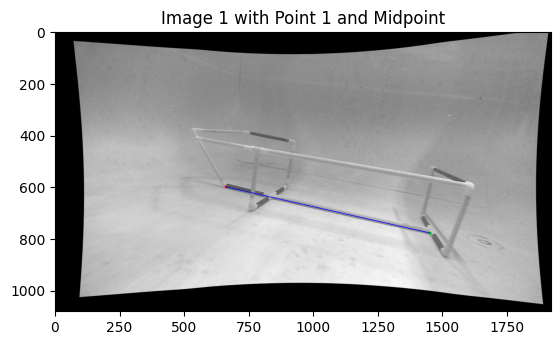

In [8]:
import numpy as np
import cv2

# Load P1, P2
P1 = np.load('P1.npy')
P2 = np.load('P2.npy')

print("P1:\n", P1)
print("P2:\n", P2)

# Extract pixel coordinates from keypoints
if len(all_valid_matches) >= 3:
    pixel_coords_left = np.array([[match['matched_pt'][0].cpu().numpy(), match['matched_pt'][1].cpu().numpy()] for match in all_valid_matches], dtype=np.float32).T
    pixel_coords_right = np.array([[match['matched_pt'][0].cpu().numpy() - match['disparity'], match['matched_pt'][1].cpu().numpy()] for match in all_valid_matches], dtype=np.float32).T

    # Triangulate points
    points_4d_hom = cv2.triangulatePoints(P1, P2, pixel_coords_left, pixel_coords_right)

    # Convert to Euclidean coordinates
    points_3d = points_4d_hom / points_4d_hom[3]

    # Get the first point
    point1_3d = points_3d[:3, 0]

    # Calculate the midpoint between the second and third points
    point2_3d = points_3d[:3, 1]
    point3_3d = points_3d[:3, 2]
    midpoint = (point2_3d + point3_3d) / 2

    # Calculate the distance between the first point and the midpoint
    distance = np.linalg.norm(point1_3d - midpoint)

    print(f"3D coordinates of Point 1: {point1_3d}")
    print(f"Midpoint between Point 2 and Point 3: {midpoint}")
    print(f"Distance between Point 1 and the midpoint: {distance}")

    # Convert 3D points to pixel coordinates in image0
    point1_pixel = cv2.projectPoints(point1_3d.reshape(-1, 1, 3), np.zeros((3, 1)), np.zeros((3, 1)), P1[:3, :3], None)[0].reshape(-1, 2)
    midpoint_pixel = cv2.projectPoints(midpoint.reshape(-1, 1, 3), np.zeros((3, 1)), np.zeros((3, 1)), P1[:3, :3], None)[0].reshape(-1, 2)

    # Draw circles at the projected pixel locations
    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    cv2.circle(img1_color, (int(point1_pixel[0][0]), int(point1_pixel[0][1])), 5, (0, 0, 255), -1)
    cv2.circle(img1_color, (int(midpoint_pixel[0][0]), int(midpoint_pixel[0][1])), 5, (0, 255, 0), -1)

    # Draw a line between the points
    cv2.line(img1_color, (int(point1_pixel[0][0]), int(point1_pixel[0][1])), (int(midpoint_pixel[0][0]), int(midpoint_pixel[0][1])), (255, 0, 0), 2)

    # Display the image
    plt.imshow(cv2.cvtColor(img1_color, cv2.COLOR_BGR2RGB))
    plt.title("Image 1 with Point 1 and Midpoint")
    plt.show()
else:
    print("Not enough valid matches (need at least 3) to calculate the distance.")